#1)	Постановка задачи


Построить математическую модель стоимости вторичного жилья в зависимости от параметров этого жилья.
В качестве источника исходных данных предлагается использовать данные сайта магнитогорской недвижимости www.citystar.ru.
*   1)	постановку задачи
*   2)	выбор и получение исходных данных
*   3)	выбор метода решения






#2)	выбор и получение исходных данных

В качестве источника исходных данных использован сайт магнитогорской недвижимости www.citystar.ru. Проведен парсинг сайта объявлений по вторичному рынку

##2.2 Анализ данных

###2.2.1 Импорт библиотек, загрузка данных

In [ ]:
#установка
!pip install plotly

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression #линейная регрессия
from sklearn.neighbors import KNeighborsRegressor  #регрессия на основе метода ближайших соседей
from sklearn.ensemble import RandomForestRegressor #случайный лес регрессия
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as sf

from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier #классификатор дерево решений, прост визуализаций
from sklearn import tree #
from sklearn.metrics import accuracy_score #метрики процент правильно угаданных ответов

#model save
import pickle

Загружаем данные

In [2]:
#загружаем данные
house_price = pd.read_excel('https://github.com/rainewan/house_price_magitogorsk/raw/main/output.xlsx')

In [3]:
#смотрим, что загрузилось
house_price.head()

,Unnamed: 0,№,date,rooms,type_flat,area,adress,flat,flats,square_all,square_live,square_kitchen,annotaion,price
0,0,1,2023-10-03,3,NaN,0,Карла Маркса 139,1,9,66.0,45.0,9.0,id:29478. \r\nПродам трехкомнатную квартиру в ...,4500
1,1,2,2023-10-03,1,NaN,0,Первостроителей 21,3,3,27.5,13.0,6.0,id:29465. \r\nВНИМАНИЕ! ЭКСКЛЮЗИВНОЕ ПРЕДЛОЖЕН...,2200
2,2,3,2023-10-03,1,хабаровский,Орджоникидзевский,50-летия Магнитки 70,1,5,35.0,17.0,9.0,"Продам однокомнатную,нестандартную квартиру в ...",2890
3,3,4,2023-10-03,3,старой,Ленинский,Куйбышева 26,3,5,66.7,43.0,9.0,Продам трехкомнатную квартиру старой планировк...,5300
4,4,5,2023-10-03,3,NaN,NaN,Карла Маркса 139,1,9,66.0,45.0,9.0,id:29478. \r\nПродам трехкомнатную квартиру в ...,4500


Описание колонок:
-    date = Column(Date) # дата объявления
-    rooms =  Column(SmallInteger) # количество комнат
-    type_flat = Column(String(200)) # тип квартиры
-    area = Column(String(200)) # район города
-    adress = Column(String(200)) # адрес
-    flat =  Column(SmallInteger) # этаж квартиры
-    flats = Column(SmallInteger) # всего этажей дома
-    square_all = Column(Float) # площадь общая
-    square_live =  Column(Float) # площадь жилая
-    square_kitchen =  Column(Float) # площадь кухни
-    annotaion = Column(String(300)) # описание
-    price = Column(Integer) # цена

In [4]:
#смотрим информацию по таблице
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Unnamed: 0      102 non-null    int64         
 1   №               102 non-null    int64         
 2   date            102 non-null    datetime64[ns]
 3   rooms           102 non-null    int64         
 4   type_flat       36 non-null     object        
 5   area            66 non-null     object        
 6   adress          102 non-null    object        
 7   flat            102 non-null    int64         
 8   flats           102 non-null    int64         
 9   square_all      102 non-null    float64       
 10  square_live     102 non-null    float64       
 11  square_kitchen  102 non-null    float64       
 12  annotaion       101 non-null    object        
 13  price           102 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(6), object(4)
memo

In [5]:
#смотрим описательную статистику параметрических данных
round(house_price.describe(),2)

,Unnamed: 0,№,rooms,flat,flats,square_all,square_live,square_kitchen,price
count,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00
mean,50.50,51.50,2.14,3.67,6.74,57.80,33.21,8.71,3869.00
std,29.59,29.59,0.92,2.48,3.61,35.66,18.46,3.65,1676.04
min,0.00,1.00,1.00,1.00,1.00,21.80,0.00,3.00,2.00
25%,25.25,26.25,1.00,2.00,4.25,37.75,19.00,6.00,2625.00
50%,50.50,51.50,2.00,3.00,5.00,52.00,32.00,8.00,3550.00
75%,75.75,76.75,3.00,5.00,9.00,65.75,45.00,9.00,4500.00
max,101.00,102.00,5.00,10.00,17.00,323.00,100.00,25.00,9055.00


Видим некорректную минимальную цену, от чего остальные показатели так же изменятся

In [ ]:
#смотрим сколько выборосов по стоимости меньше 1000
house_price.query("price < 1000")

,Unnamed: 0,№,date,rooms,type_flat,area,adress,flat,flats,square_all,square_live,square_kitchen,annotaion,price
81,81,82,2023-09-24,1,NaN,NaN,Бориса Ручьева 8/1,1,5,33.0,20.0,6.0,id:28050. \r\nХарактеристика:\r\nПродам одноко...,2
86,86,87,2023-09-22,3,NaN,NaN,Школьная 10,1,1,59.5,47.0,12.0,id:28866. \r\nПродам 3-комнатную квартиру или ...,500


Text(0.5, 1.0, 'Распределение цены относительно площади жилья')

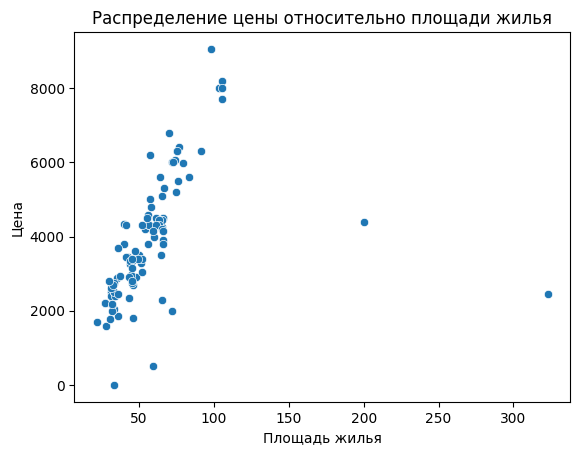

In [ ]:
#рисуем график точек цены от квадратов
sns.scatterplot(data=house_price, x="square_all", y="price")
plt.xlabel('Площадь жилья')
plt.ylabel('Цена')
plt.title('Распределение цены относительно площади жилья')

Видим так же два выброса явных свыше 150кв.м., где общее количество квадратов очень большое, а жилих из них в несколько раз меньше

In [ ]:
#смотрим сколько выборосов по стоимости меньше 1000
house_price.query("square_all > 150")

,Unnamed: 0,№,date,rooms,type_flat,area,adress,flat,flats,square_all,square_live,square_kitchen,annotaion,price
50,50,51,2023-09-27,5,NaN,NaN,Ленина пр-т 210 стр.А,1,1,200.0,100.0,25.0,id:1077. \r\nВыгодное вложение в свой отдых в ...,4400
91,91,92,2023-09-20,1,NaN,NaN,Московская 81,1,3,323.0,17.0,6.0,id:28623. \r\nПродам однокомнатную квартиру в ...,2450


Убираем эти выбросы, где некорректно указана минимальная цена и общая площадь

In [ ]:
#удаляем выбросы так цена в двух однокомнатных и одной пятикомнатной аномальная
house_price_without_noise = house_price.query("price > 1000 and square_all < 150")

In [ ]:
#смотрим описательную статистику параметрических данных без выбросов
round(house_price_without_noise.describe(),2)

,Unnamed: 0,№,rooms,flat,flats,square_all,square_live,square_kitchen,price
count,98.00,98.00,98.00,98.00,98.00,98.00,98.00,98.00,98.00
mean,49.42,50.42,2.12,3.78,6.91,53.88,32.69,8.56,3951.90
std,29.51,29.51,0.88,2.47,3.57,19.20,17.38,3.30,1619.62
min,0.00,1.00,1.00,1.00,1.00,21.80,0.00,3.00,1600.00
25%,24.25,25.25,1.00,2.00,5.00,37.75,19.00,6.00,2712.50
50%,48.50,49.50,2.00,3.00,5.00,52.00,32.00,8.00,3650.00
75%,73.75,74.75,3.00,5.00,9.00,65.22,45.00,9.00,4500.00
max,101.00,102.00,4.00,10.00,17.00,105.00,83.00,25.00,9055.00


Text(0.5, 1.0, 'Распределение цены относительно площади жилья')

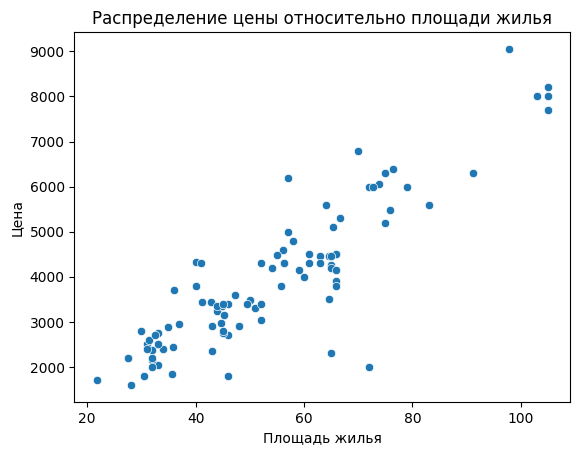

In [ ]:
#рисуем график точек цены от квадратов
sns.scatterplot(data=house_price_without_noise, x="square_all", y="price")
plt.xlabel('Площадь жилья')
plt.ylabel('Цена')
plt.title('Распределение цены относительно площади жилья')

In [ ]:
#считаем количество уникальных значений по таблице
house_price_without_noise.nunique()

Unnamed: 0        98
№                 98
date              17
rooms              4
type_flat         12
area               6
adress            93
flat              10
flats             13
square_all        67
square_live       41
square_kitchen    22
annotaion         95
price             68
dtype: int64

Смотрим пропуски

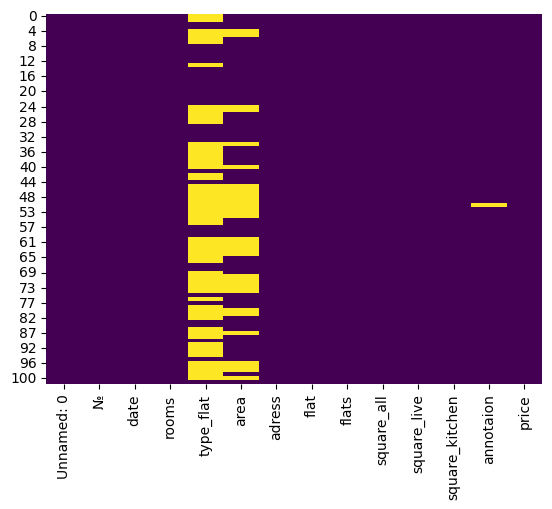

In [ ]:
#строим графическое отображение пропусков
sns.heatmap(house_price_without_noise.isna(), cmap = 'viridis', cbar = False)
plt.show()

Основная часть пропусков - тип квартиры и район города



In [ ]:
#считаем пропуски по колонкам
house_price_without_noise.isnull().sum()

Unnamed: 0         0
№                  0
date               0
rooms              0
type_flat         62
area              32
adress             0
flat               0
flats              0
square_all         0
square_live        0
square_kitchen     0
annotaion          1
price              0
dtype: int64

In [ ]:
#считаем процент пропусков по району города
house_price_without_noise['area'].isna().sum() / house_price_without_noise.shape[0] * 100

32.6530612244898

###2.2.2 Изучаем целевую переменную

Text(0.5, 1.0, 'Распределения количества объявлений по стоимости')

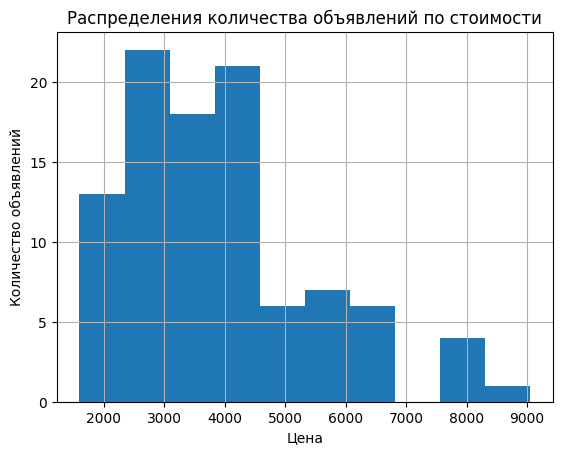

In [ ]:
#построим гистограмму распределения количества объявлений по стоимости
house_price_without_noise['price'].hist()
plt.xlabel('Цена')
plt.ylabel('Количество объявлений')
plt.title('Распределения количества объявлений по стоимости')

,Unnamed: 0,№,date,rooms,type_flat,area,adress,flat,flats,square_all,square_live,square_kitchen,annotaion,price
18,18,19,2023-10-01,3,нестандартная,Орджоникидзевский,Ленина пр-т 129,5,16,105.0,75.0,14.0,"Отличная 3-х комнатная кв-ра, заезжай и живи!!...",7700
41,41,42,2023-09-28,3,нестандартная,Орджоникидзевский,50-летия Магнитки 51а,7,10,103.0,70.0,25.0,В продаже замечательная 3-комнатная квартира в...,8000
42,42,43,2023-09-28,3,NaN,Орджоникидзевский,Ленина пр-т 129/2,6,9,105.0,78.0,14.0,Продам 3-х комнатную квартиру\r\nпремиум-класс...,8200
68,68,69,2023-10-02,3,нестандартная,Правобережный,Мичурина 136/2,9,9,97.9,64.0,12.0,Продажа от собственника. Все документы готовы ...,9055
76,76,77,2023-09-30,4,NaN,Орджоникидзевский,Карла Маркса 185,4,9,105.0,83.0,10.0,Предлагаю Вашему вниманию четырёхкомнатную ква...,8000


Правосторонняя ассиметрия данных

Text(0.5, 1.0, 'Распределение цены относительно площади жилья')

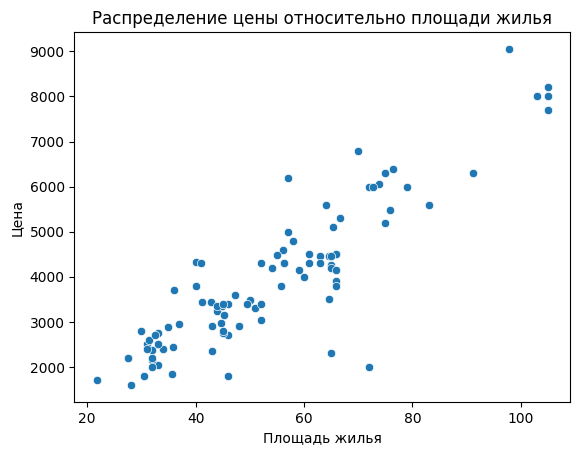

In [ ]:
#рисуем график точек цены от квадратов
sns.scatterplot(data=house_price_without_noise, x="square_all", y="price")
plt.xlabel('Площадь жилья')
plt.ylabel('Цена')
plt.title('Распределение цены относительно площади жилья')

Наблюдается зависимость цены от общей площади недвижимости

In [ ]:
#добавим столбец средняя цена за квадрат
house_price_without_noise['square_price']=house_price_without_noise['price']/house_price_without_noise['square_all']
house_price_without_noise.head().round(2)

<ipython-input-19-4eb63c7e40fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_price_without_noise['square_price']=house_price_without_noise['price']/house_price_without_noise['square_all']


,Unnamed: 0,№,date,rooms,type_flat,area,adress,flat,flats,square_all,square_live,square_kitchen,annotaion,price,square_price
0,0,1,2023-10-03,3,NaN,0,Карла Маркса 139,1,9,66.0,45.0,9.0,id:29478. \r\nПродам трехкомнатную квартиру в ...,4500,68.18
1,1,2,2023-10-03,1,NaN,0,Первостроителей 21,3,3,27.5,13.0,6.0,id:29465. \r\nВНИМАНИЕ! ЭКСКЛЮЗИВНОЕ ПРЕДЛОЖЕН...,2200,80.00
2,2,3,2023-10-03,1,хабаровский,Орджоникидзевский,50-летия Магнитки 70,1,5,35.0,17.0,9.0,"Продам однокомнатную,нестандартную квартиру в ...",2890,82.57
3,3,4,2023-10-03,3,старой,Ленинский,Куйбышева 26,3,5,66.7,43.0,9.0,Продам трехкомнатную квартиру старой планировк...,5300,79.46
4,4,5,2023-10-03,3,NaN,NaN,Карла Маркса 139,1,9,66.0,45.0,9.0,id:29478. \r\nПродам трехкомнатную квартиру в ...,4500,68.18


In [ ]:
#создаем таблицу для корреляции данных
corr_table = house_price_without_noise[['rooms',	'flat',	'flats',	'square_all',	'square_live',	'square_kitchen', 'price', 'square_price']].copy()

                   rooms      flat     flats  square_all  square_live  \
rooms           1.000000  0.136712  0.013525    0.853635     0.779278   
flat            0.136712  1.000000  0.559635    0.205215     0.069810   
flats           0.013525  0.559635  1.000000    0.168181    -0.040333   
square_all      0.853635  0.205215  0.168181    1.000000     0.826094   
square_live     0.779278  0.069810 -0.040333    0.826094     1.000000   
square_kitchen  0.292636  0.205504  0.303557    0.567929     0.420077   
price           0.691808  0.267078  0.247925    0.888495     0.727600   
square_price   -0.142293  0.199487  0.246025   -0.020576    -0.044130   

                square_kitchen     price  square_price  
rooms                 0.292636  0.691808     -0.142293  
flat                  0.205504  0.267078      0.199487  
flats                 0.303557  0.247925      0.246025  
square_all            0.567929  0.888495     -0.020576  
square_live           0.420077  0.727600     -0.044130  


<function matplotlib.pyplot.show(close=None, block=None)>

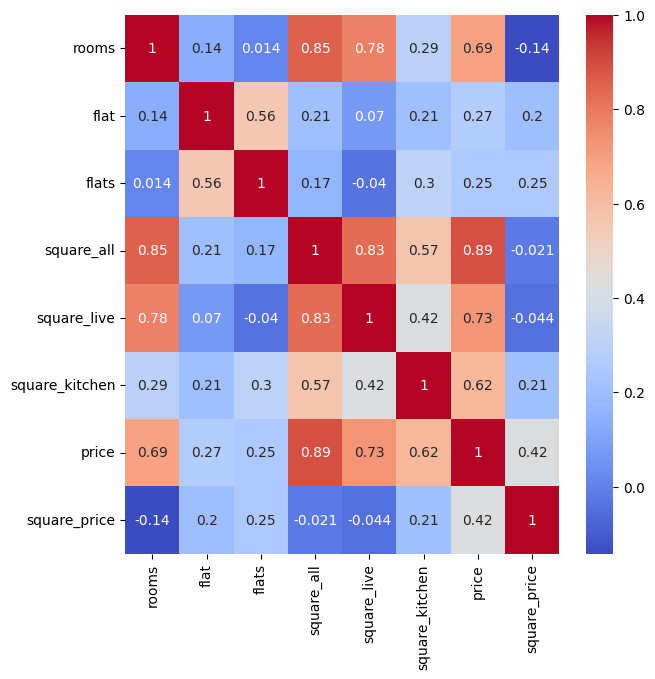

In [ ]:
#вывод таблицы корреляции
print(corr_table.corr())
plt.figure(figsize= (7,7))
sns.heatmap(corr_table.corr(), cmap = 'coolwarm',annot = True)
plt.show

По данным таблицы корреляции, есть связь между ценой и количеством общих квадратов жилья. И что естественно зависимость между количеством комнат и жилой площадью.

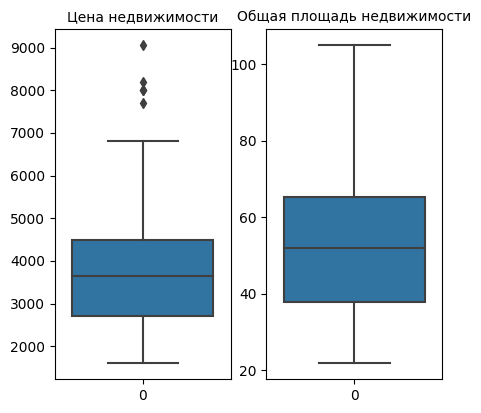

In [ ]:
#построим boxplot по распределению цены и общей площади
plt.figure(figsize=[5, 10])

plt.subplot(2,2,1)
sns.boxplot(house_price_without_noise['price'])
plt.title('Цена недвижимости', fontsize=10, y=1)

plt.subplot(2,2,2)
sns.boxplot(house_price_without_noise['square_all'])
plt.title('Общая площадь недвижимости', fontsize=10, y=1)

plt.show()

Наблюдаются некоторые данные в верхней части, где цены за звадрат гораздо выше средних. Это высокооценный сегмент (элитное жилье/элитный район)

In [7]:
house_price.query("price > 7000")

,Unnamed: 0,№,date,rooms,type_flat,area,adress,flat,flats,square_all,square_live,square_kitchen,annotaion,price
18,18,19,2023-10-01,3,нестандартная,Орджоникидзевский,Ленина пр-т 129,5,16,105.0,75.0,14.0,"Отличная 3-х комнатная кв-ра, заезжай и живи!!...",7700
41,41,42,2023-09-28,3,нестандартная,Орджоникидзевский,50-летия Магнитки 51а,7,10,103.0,70.0,25.0,В продаже замечательная 3-комнатная квартира в...,8000
42,42,43,2023-09-28,3,NaN,Орджоникидзевский,Ленина пр-т 129/2,6,9,105.0,78.0,14.0,Продам 3-х комнатную квартиру\r\nпремиум-класс...,8200
68,68,69,2023-10-02,3,нестандартная,Правобережный,Мичурина 136/2,9,9,97.9,64.0,12.0,Продажа от собственника. Все документы готовы ...,9055
76,76,77,2023-09-30,4,NaN,Орджоникидзевский,Карла Маркса 185,4,9,105.0,83.0,10.0,Предлагаю Вашему вниманию четырёхкомнатную ква...,8000


Построим qqplot для оценки нормальности распределения

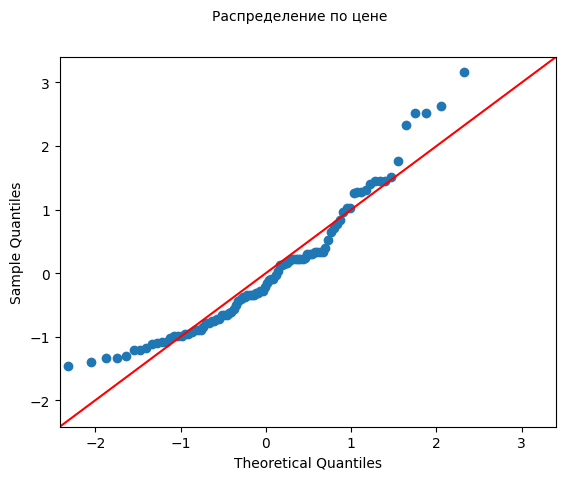

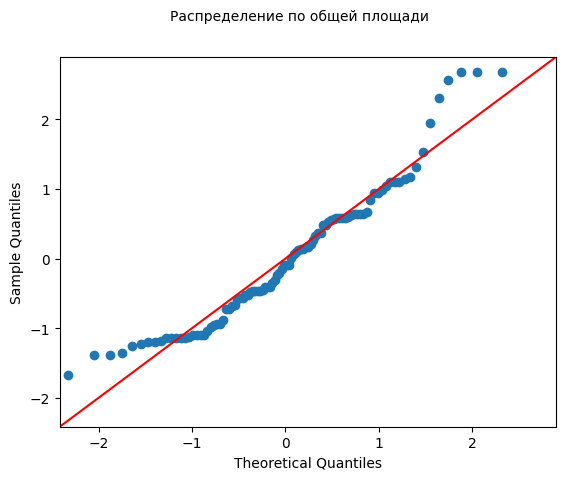

In [ ]:
#fig = make_subplots(rows=1, cols=2)
fig = sm.graphics.qqplot(house_price_without_noise['price'], dist=stats.norm, line='45', fit=True)
fig.suptitle('Распределение по цене', fontsize=10)
fig = sm.graphics.qqplot(house_price_without_noise['square_all'], dist=stats.norm, line='45', fit=True)
fig.suptitle('Распределение по общей площади', fontsize=10)

plt.show()

Большинство укладываются в нормальное распределение. С краев наблюдается отклонение

In [ ]:
#смотрим описание цены за квадрат по районам
house_price_without_noise.groupby('area',as_index = False).aggregate({'square_price': 'describe'})


area square_price                        \
                                          count       mean        std   
0                                0          2.0  74.090909   8.356717   
1                        Ленинский         15.0  72.080111   8.883260   
2          Ленинский (Левый берег)          1.0  54.095827        NaN   
3                Орджоникидзевский         30.0  78.290517   8.544157   
4  Орджоникидзевский (левый берег)          3.0  39.271185  13.851851   
5                    Правобережный         15.0  78.382622  12.562680   

                                                           
         min        25%        50%        75%         max  
0  68.181818  71.136364  74.090909  77.045455   80.000000  
1  57.142857  66.956416  72.427441  80.033873   83.769634  
2  54.095827  54.095827  54.095827  54.095827   54.095827  
3  64.615385  73.478261  77.559536  82.791566  104.878049  
4  27.777778  31.581197  35.384615  45.017889   54.651163  
5  58.881579  69.210936  76.241135  83.538462  108.250000

##Вывод по данным: в зависимости от района сильно отличается цена за квадратный метр. И это нагляднее всего дает ориентир для оценки стоимости жилья.

Мультирегрессия OLS (метод наименьших квадратов Ordinary Least Squares) для определения Значимых коэффициентов

In [ ]:
#все
mult_regr = sm.OLS.from_formula(formula='price ~ square_all + rooms + flat + flats + square_kitchen + C(area)', data=house_price_without_noise).fit()
mult_regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     56.78
Date:                Sun, 19 Nov 2023   Prob (F-statistic):           2.44e-25
Time:                        13:19:41   Log-Likelihood:                -502.59
No. Observations:                  66   AIC:                             1027.
Df Residuals:                      55   BIC:                             1051.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                    -47.6454    443.986     -0.107      0.915    -937.413     842.122
C(area)[T.Ленинский]                         -69.2232    414.170     -0.167      0.868    -899.237     760.791
C(area)[T.Ленинский (Левый берег)]         -1078.9950    666.327     -1.619      0.111   -2414.345     256.355
C(area)[T.Орджоникидзевский]                 228.4650    407.137      0.561      0.577    -587.456    1044.386
C(area)[T.Орджоникидзевский (левый берег)] -2055.2557    500.232     -4.109      0.000   -3057.744   -1052.768
C(area)[T.Правобережный]                     355.0636    409.128      0.868      0.389    -464.848    1174.975
square_all                                    83.0920      7.948     10.455      0.000      67.164      99.020
rooms                                       -308.8295    156.486     -1.974      0.053    -622.435       4.776
flat                                          17.2034     30.625      0.562      0.577     -44.170      78.577
flats                                        -30.5638     27.357     -1.117      0.269     -85.388      24.260
square_kitchen                                37.2970     29.844      1.250      0.217     -22.511      97.105
==============================================================================
Omnibus:                        3.108   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.211   Jarque-Bera (JB):                2.554
Skew:                           0.479   Prob(JB):                        0.279
Kurtosis:                       3.108   Cond. No.                         932.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Вверху общая таблица со всеми параметрами,
P>t меньше 0.05 означает статистическую значимость в следюущих столбцах:
- количество квадратов (статистически влияет на стоимость в высоким коэффициентом)
- Орджоникидзевский (левый берег) (этот район влияет статистически на цену)

In [ ]:
mult_regr2 = sm.OLS.from_formula(formula='price ~ square_all + C(area)', data=house_price_without_noise).fit()
mult_regr2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     85.47
Date:                Sun, 19 Nov 2023   Prob (F-statistic):           3.10e-27
Time:                        13:19:41   Log-Likelihood:                -507.73
No. Observations:                  66   AIC:                             1029.
Df Residuals:                      59   BIC:                             1045.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                   -134.1387    429.256     -0.312      0.756    -993.078     724.801
C(area)[T.Ленинский]                          47.0556    425.467      0.111      0.912    -804.303     898.414
C(area)[T.Ленинский (Левый берег)]         -1187.7602    690.125     -1.721      0.090   -2568.698     193.178
C(area)[T.Орджоникидзевский]                 290.6675    412.150      0.705      0.483    -534.042    1115.378
C(area)[T.Орджоникидзевский (левый берег)] -2120.8165    514.348     -4.123      0.000   -3150.025   -1091.608
C(area)[T.Правобережный]                     371.4935    422.738      0.879      0.383    -474.404    1217.391
square_all                                    74.5270      3.503     21.274      0.000      67.517      81.537
==============================================================================
Omnibus:                        5.133   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.077   Jarque-Bera (JB):                4.278
Skew:                           0.589   Prob(JB):                        0.118
Kurtosis:                       3.407   Cond. No.                         903.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Модель с высокой площадью охвата данных с учетом района

Возьмем для этого среднюю за квадрат исходя из района

In [ ]:
#создаем таблицу средняя цена за квадрат в зависимости от района
mean_house_price_without_noise = house_price_without_noise.groupby('area',as_index = False).aggregate({'square_price':'mean'}).rename(columns = {'square_price':'mean_square_price'})
mean_house_price_without_noise.round(2)

,area,mean_square_price
0,0,74.09
1,Ленинский,72.08
2,Ленинский (Левый берег),54.10
3,Орджоникидзевский,78.29
4,Орджоникидзевский (левый берег),39.27
5,Правобережный,78.38


# 3) выбор метода решения

### 3.1 Базовая модель

Итого получается средную стоймость квартиры можно рассчитать исходя из цены за квадрат для базовой модели в зависимости от района:
- Ленинский 72,08
- Ленинский (Левый берег)	54.10
- Орджоникидзевский	78.29
- Орджоникидзевский (левый берег)	39.27
- Правобережный	78.38

In [ ]:
#считаем ошибку для четвертой строчки квартиры в районе Ленинский
act=[5300]
pred_hand = 72.08*66.7
print(pred_hand)


4807.736


In [ ]:
#ошибка MSE среднеквадратичная ошибка
pred=[4808]
mean_squared_error(act, pred)

242064.0

In [ ]:
#процент прогноза
procent_prognoza = 4808/5300
print(procent_prognoza)

0.9071698113207547


In [ ]:
#скопируем данные для подготовки модели
data_XY = house_price_without_noise.copy()
data_XY.head()

,Unnamed: 0,№,date,rooms,type_flat,area,adress,flat,flats,square_all,square_live,square_kitchen,annotaion,price,square_price
0,0,1,2023-10-03,3,NaN,0,Карла Маркса 139,1,9,66.0,45.0,9.0,id:29478. \r\nПродам трехкомнатную квартиру в ...,4500,68.181818
1,1,2,2023-10-03,1,NaN,0,Первостроителей 21,3,3,27.5,13.0,6.0,id:29465. \r\nВНИМАНИЕ! ЭКСКЛЮЗИВНОЕ ПРЕДЛОЖЕН...,2200,80.000000
2,2,3,2023-10-03,1,хабаровский,Орджоникидзевский,50-летия Магнитки 70,1,5,35.0,17.0,9.0,"Продам однокомнатную,нестандартную квартиру в ...",2890,82.571429
3,3,4,2023-10-03,3,старой,Ленинский,Куйбышева 26,3,5,66.7,43.0,9.0,Продам трехкомнатную квартиру старой планировк...,5300,79.460270
4,4,5,2023-10-03,3,NaN,NaN,Карла Маркса 139,1,9,66.0,45.0,9.0,id:29478. \r\nПродам трехкомнатную квартиру в ...,4500,68.181818


In [ ]:

#оставим только строки с имеющимся районами
data_XY.dropna(subset=['area'], inplace=True, how='all') #удаление пропусков NaN (отсутствуют значения)
data_XY.head()

,Unnamed: 0,№,date,rooms,type_flat,area,adress,flat,flats,square_all,square_live,square_kitchen,annotaion,price,square_price
0,0,1,2023-10-03,3,NaN,0,Карла Маркса 139,1,9,66.0,45.0,9.0,id:29478. \r\nПродам трехкомнатную квартиру в ...,4500,68.181818
1,1,2,2023-10-03,1,NaN,0,Первостроителей 21,3,3,27.5,13.0,6.0,id:29465. \r\nВНИМАНИЕ! ЭКСКЛЮЗИВНОЕ ПРЕДЛОЖЕН...,2200,80.000000
2,2,3,2023-10-03,1,хабаровский,Орджоникидзевский,50-летия Магнитки 70,1,5,35.0,17.0,9.0,"Продам однокомнатную,нестандартную квартиру в ...",2890,82.571429
3,3,4,2023-10-03,3,старой,Ленинский,Куйбышева 26,3,5,66.7,43.0,9.0,Продам трехкомнатную квартиру старой планировк...,5300,79.460270
6,6,7,2023-10-03,1,NaN,Правобережный,Западное шоссе 101,1,2,40.0,23.0,8.0,pВ продаже квартира в поселке Зелёная долина ...,4330,108.250000


In [ ]:
#удаление пропусков нулевых (отсутствуют значения) в районах
data_XY = data_XY[data_XY.area != 0 ] #

In [ ]:
#смотрим уникальные значения по районам
data_XY.area.unique()

array(['Орджоникидзевский', 'Ленинский', 'Правобережный',
       'Орджоникидзевский (левый берег)', 'Ленинский (Левый берег)'],
      dtype=object)

In [ ]:
#кодируем районы цифрами для отображения на графиках
le = LabelEncoder() #создаем объект для кодирования
le.fit(data_XY['area']) #сопоставляем объект для кодирования с районом

data_XY['area_le'] = le.transform(data_XY['area']) #добавляем колонку с кодированием района
data_XY['area_le'].value_counts() #смотрим по количеству каждого района

2    30
0    15
4    15
3     3
1     1
Name: area_le, dtype: int64

###Подготовка данных

In [ ]:
#y = np.array(house_price_without_noise[['price']])
#X = np.array(house_price_without_noise[['square_all', 'rooms', 'area_le']])

y = np.array(data_XY[['price']])
X = np.array(data_XY[['square_all', 'area_le']])

In [ ]:
X[1]

array([66.7,  0. ])

In [ ]:
y[1]

array([5300])

###Масштабируем данные

In [ ]:
scaler = StandardScaler()
scaler.fit(X) # pkl
X_scaled = scaler.fit_transform(X)

In [ ]:
#Сохраняем модель scaler
pickle.dump(scaler, open('X_scaled.pkl', 'wb'))

###Разбиваем выборку на тренировочную и тестовую

In [ ]:
#создаем разбивку по данных на тестовую и проверочную
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state = 42)

In [ ]:
#проверяем размерность
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(51, 2)
(51, 1)
(13, 2)
(13, 1)


###Cоздаем таблицу результатов

In [ ]:
#создаем таблицу результатов
result_table = pd.DataFrame()
result_table['Метрики'] = ['MAPE', 'MSE', 'MAE']

##3.2 ML

###Linear regression

In [ ]:
##Linear regression
lr = LinearRegression()
#параметры сетки
#param_grid = {'normalize' : [True, False]} было
param_grid = {'copy_X' : [True, False],
               'fit_intercept' : [True, False],
               'n_jobs' : [1,2,3],
               'positive' : [True, False]}

lr_grid = GridSearchCV(lr,
                       param_grid = param_grid,
                       cv = 5)
#обучаем сетку
lr_grid.fit(X_train, y_train)
print(f'Лучшие параметры : {lr_grid.best_params_}')
print(f'ЛУчшая точность : {lr_grid.best_score_}')

Лучшие параметры : {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'positive': True}
ЛУчшая точность : 0.7825059680382731


In [ ]:
#pervaya_stroka = [66]
#lr_grid.predict(pervaya_stroka).round(2)

In [ ]:
#тест на некоторых семи значениях
lr_grid.predict(X_test[:7]).round(2)

array([[2969.41],
       [2423.98],
       [2516.56],
       [4707.33],
       [4109.06],
       [4227.8 ],
       [4780.78]])

In [ ]:
#Значения исходные
print(y_test[:7])

[[4300]
 [2700]
 [2890]
 [5100]
 [4590]
 [4300]
 [4450]]


In [ ]:
y_pred = lr_grid.predict(X_test).round(2)
print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
result_table['Линейная регрессия'] = mean_absolute_percentage_error(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred)

0.12004271082646775
380303.278923077
487.1138461538461


###Регрессия Случайный лес

In [ ]:
#Регрессия Случайный лес
rf =  RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

<ipython-input-49-d670f7498c91>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [ ]:
y_pred = rf.predict(X_test).round(2)
print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
result_table['RandomForest'] = mean_absolute_percentage_error(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred)

0.10427717957672376
279666.6552
418.8276923076923


###Регрессия К ближайших соседей

In [ ]:
#Регрессия К ближайших соседей
kNNr = KNeighborsRegressor()
#параметры сетки
param_grid = {'n_neighbors' : [4, 6, 10, 13]}
kNNr_grid = GridSearchCV(kNNr,
                       param_grid = param_grid,
                       cv = 5)
#обучаем сетку
kNNr_grid.fit(X_train, y_train)
print(f'Лучшие параметры : {kNNr_grid.best_params_}')
print(f'ЛУчшая точность : {kNNr_grid.best_score_}')

Лучшие параметры : {'n_neighbors': 6}
ЛУчшая точность : 0.6910916370458944


In [ ]:
y_pred = kNNr_grid.predict(X_test).round(2)
print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
result_table['Ближайших соседей'] = mean_absolute_percentage_error(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred)

0.11016612931222466
312724.8407769231
436.42384615384617


###Регрессия xgb

In [ ]:
###Регрессия xgb
model_xgb = xgboost.XGBRegressor(n_estimators=700, n_jobs=2, min_samples_split=2)
model_xgb.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:19:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, min_samples_split=2, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=700,
             n_jobs=2, num_parallel_tree=None, ...)

In [ ]:
y_pred = model_xgb.predict(X_test).round(2)
print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
result_table['XGB'] = mean_absolute_percentage_error(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred)

0.08178644216107879
192153.57956287952
327.0200007512019


In [ ]:
#Сохраняем модель scaler
pickle.dump(model_xgb, open('xgb_model_v1.pkl', 'wb'))
load_model = pickle.load(open('xgb_model_v1.pkl', 'rb'))

###Результирующая таблица



In [ ]:
#Результирующая таблица
print(result_table)

  Метрики  Линейная регрессия   RandomForest  Ближайших соседей            XGB
0    MAPE            0.120043       0.104277           0.110166       0.081786
1     MSE       380303.278923  279666.655200      312724.840777  192153.579563
2     MAE          487.113846     418.827692         436.423846     327.020001


##3.3 Вывод: для модели будем использовать XGB, так как у него меньше всего метрики ошибок